<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Farm_ID                    50 non-null     object 
 1   Crop_Type                  50 non-null     object 
 2   Farm_Area(acres)           50 non-null     float64
 3   Irrigation_Type            50 non-null     object 
 4   Fertilizer_Used(tons)      50 non-null     float64
 5   Pesticide_Used(kg)         50 non-null     float64
 6   Yield(tons)                50 non-null     float64
 7   Soil_Type                  50 non-null     object 
 8   Season                     50 non-null     object 
 9   Water_Usage(cubic meters)  50 non-null     float64
dtypes: float64(5), object(5)
memory usage: 4.0+ KB
None
Farm_ID                      0
Crop_Type                    0
Farm_Area(acres)             0
Irrigation_Type              0
Fertilizer_Used(tons)        0
Pesticide_Use

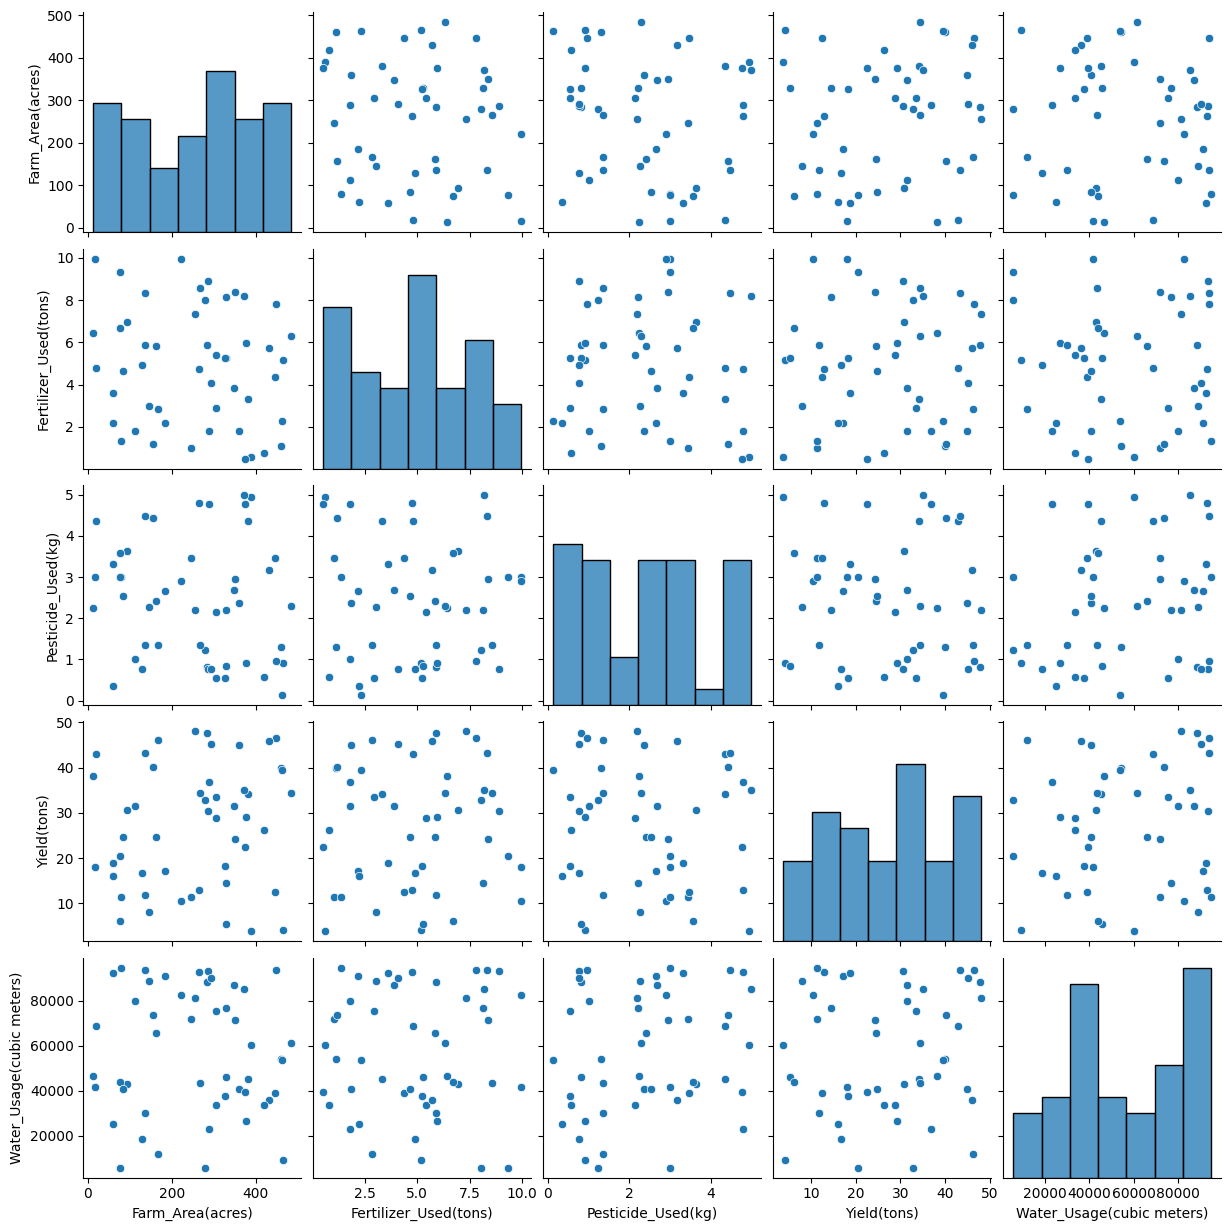

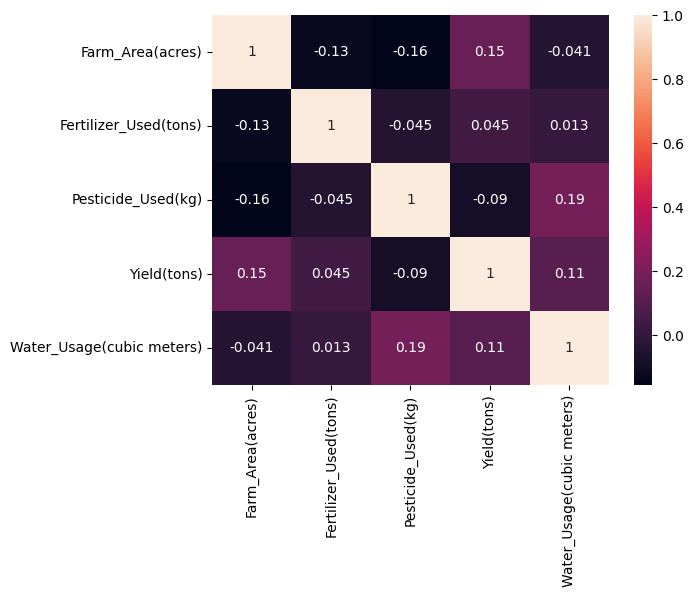

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
df = pd.read_csv("C:/CW project/agriculture_dataset.csv")

# Check for missing values and data types
print(df.info())
print(df.isnull().sum())
print(df.describe())

# Visual EDA (optional)
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

# Encode categorical variables
cat_cols = ['Crop_Type', 'Irrigation_Type', 'Soil_Type', 'Season']
df_encoded = df.copy()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save for later use

# Drop non-useful column
df_encoded.drop("Farm_ID", axis=1, inplace=True)

# Scale numerical features
num_cols = [
    'Farm_Area(acres)',
    'Fertilizer_Used(tons)',
    'Pesticide_Used(kg)',
    'Water_Usage(cubic meters)'
]
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Split into features and target
X = df_encoded.drop("Yield(tons)", axis=1)
y = df_encoded["Yield(tons)"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Linear Regression - MAE: 10.63, RMSE: 12.63
Random Forest - MAE: 10.91, RMSE: 13.43
Gradient Boosting - MAE: 14.27, RMSE: 16.45


In [5]:
from sklearn.linear_model import LinearRegression
import pickle

# Train the best model
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Save model
with open("yield_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Save encoders & scaler
with open("encoders_scaler.pkl", "wb") as f:
    pickle.dump((label_encoders, scaler), f)


In [6]:
import pandas as pd

# Reload the original dataset
df = pd.read_csv("C:/CW project/agriculture_dataset.csv")

# Columns to check for outliers
num_cols = [
    'Farm_Area(acres)',
    'Fertilizer_Used(tons)',
    'Pesticide_Used(kg)',
    'Water_Usage(cubic meters)',
    'Yield(tons)'
]

# IQR method to cap outliers
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap values beyond bounds
    df[col] = df[col].clip(lower_bound, upper_bound)

# Confirm cleanup
print(df[num_cols].describe())


       Farm_Area(acres)  Fertilizer_Used(tons)  Pesticide_Used(kg)  \
count         50.000000              50.000000           50.000000   
mean         254.963800               4.905400            2.398000   
std          139.417782               2.732689            1.438613   
min           12.500000               0.500000            0.140000   
25%          135.710000               2.437500            0.972500   
50%          281.980000               5.045000            2.330000   
75%          368.107500               6.885000            3.417500   
max          483.880000               9.960000            4.990000   

       Water_Usage(cubic meters)  Yield(tons)  
count                  50.000000    50.000000  
mean                56724.295600    27.059200  
std                 27264.992053    13.345789  
min                  5869.750000     3.860000  
25%                 37818.152500    16.190000  
50%                 54097.075000    28.970000  
75%                 82240.032500 

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Columns
categorical_cols = ['Crop_Type', 'Irrigation_Type', 'Soil_Type', 'Season']
numerical_cols = ['Farm_Area(acres)', 'Fertilizer_Used(tons)', 'Pesticide_Used(kg)', 'Water_Usage(cubic meters)']
target_col = 'Yield(tons)'

# Encode categoricals
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature matrix and target
X = df[categorical_cols + numerical_cols]
y = df[target_col]

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\USER\AppData\Local\Temp\ipykernel_5320\3023845896.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Linear Regression - MAE: 10.63, RMSE: 12.63
Random Forest - MAE: 11.05, RMSE: 13.51
Gradient Boosting - MAE: 13.83, RMSE: 16.12
